# Model

In [54]:
### Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline


from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.metrics import plot_confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.compose import make_column_transformer

In [40]:
## Import data
df = pd.read_csv('../data/subreddit_comments.csv')

In [41]:
# Check DataFrame
df.head()

,subreddit,body,clean_body
0,formuladank,If the sun is reporting it then it wouldn’t be...,if the sun is reporting it then it wouldn’t be...
1,formuladank,Micheal masi's answer : 1,micheal masi's answer : 1
2,formuladank,it's all fun and games till charles and carlos...,it's all fun and games till charles and carlos...
3,formuladank,# #stillwerise,# #stillwerise
4,formuladank,2.99??????? wtf,2.99??????? wtf


In [3]:
## Create X and y
X = df['clean_body']
y = df['subreddit']

In [6]:
# Baseline (Even though we know this should be a 50/50 split)
y.value_counts(normalize = True)

formuladank    0.5
formula1       0.5
Name: subreddit, dtype: float64

In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Start with standard model combinations (Count Vectorizer/TF-IDF and Naive Bayes/Logistic Regression)
----

### CVEC and Naive Bayes

In [7]:
# Pipeline
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Fit 
pipe_cvec_nb.fit(X_train, y_train)

# Scores
print(f'Train: {pipe_cvec_nb.score(X_train, y_train)}')
print(f'Test: {pipe_cvec_nb.score(X_test, y_test)}')

Train: 0.7970666666666667
Test: 0.6526


### CVEC and Logistic Regression

In [8]:
# Pipeline
pipe_cvec_log = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', LogisticRegression(max_iter = 10_000))
])

# Fit 
pipe_cvec_log.fit(X_train, y_train)

# Scores
print(f'Train: {pipe_cvec_log.score(X_train, y_train)}')
print(f'Test: {pipe_cvec_log.score(X_test, y_test)}')

Train: 0.8737333333333334
Test: 0.6612


### TF-IDF and Naive Bayes

In [9]:
# Pipeline
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Fit 
pipe_tvec_nb.fit(X_train, y_train)

# Scores
print(f'Train: {pipe_tvec_nb.score(X_train, y_train)}')
print(f'Test: {pipe_tvec_nb.score(X_test, y_test)}')

Train: 0.7995333333333333
Test: 0.6458


### TF-IDF and Logistic Regression

In [10]:
# Pipeline
pipe_tvec_log = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

# Fit 
pipe_tvec_log.fit(X_train, y_train)

# Scores
print(f'Train: {pipe_tvec_log.score(X_train, y_train)}')
print(f'Test: {pipe_tvec_log.score(X_test, y_test)}')

Train: 0.7951333333333334
Test: 0.6624


Out of these, Logistic Regression is definitely performing better than Naive Bayes. CVEC and TF-IDF are close, however TF-IDF is giving us a test score much closer to our training score which implies it is less subject to overfitting.

We also see that every model outperforms our baseline accuracy of 50%.

#### Predictions/Confusion Matrix for our TF-IDF/Logistic Regression Model
----

              precision    recall  f1-score   support

    formula1       0.66      0.66      0.66      2500
 formuladank       0.66      0.66      0.66      2500

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



C:\Users\rmped\miniconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


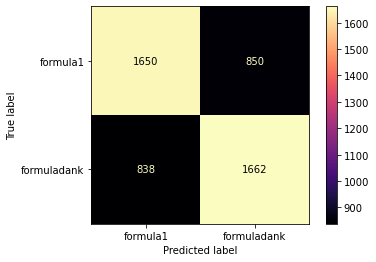

In [11]:
preds = pipe_tvec_log.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(pipe_tvec_log, X_test, y_test, cmap = 'magma');

The model doesn't seem to be particularly favored toward false classifications either way.

## Grid Search on TF-IDF/Logistic Regression
----

In [12]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5)

In [13]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('log',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [14]:
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.7646
Test: 0.6626
Best Params: {'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


This gave us an ever so slightly better model. Because the max features was on the upper end, I will create a new gridsearch with a higher max features. Will also try to increase ngram to 1,3.

In [15]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

pipe_params = {
    'tvec__max_features': [5_000, 6_000, 7_000, 8_000, 9_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 3)]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.7751333333333333
Test: 0.6628
Best Params: {'tvec__max_features': 7000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


Slightly better with max features at 7000, all other params are the same. Lets add new params.

In [16]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('log', LogisticRegression(max_iter=10000))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'log': LogisticRegression(max_iter=10000),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 10000,
 'log__multi_class': 'auto',
 'log__n_jobs': Non

In [17]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

pipe_params = {
    'tvec__max_features': [7_000],
    'tvec__max_df': [.5, .75, .95],
    'tvec__min_df': [50, 150, 400]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.6851333333333334
Test: 0.6498
Best Params: {'tvec__max_df': 0.5, 'tvec__max_features': 7000, 'tvec__min_df': 50}


In [22]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

pipe_params = {
    'tvec__max_features': [7_000],
    'tvec__max_df': [.25, .3, .35, .4, .45],
    'tvec__min_df': [1, 5, 10]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.7732666666666667
Test: 0.665
Best Params: {'tvec__max_df': 0.25, 'tvec__max_features': 7000, 'tvec__min_df': 1}


Nailed down what seems to be the best parameters as far as these go. Lets move on to preprocessing parameters.

In [16]:
# Function for lemmatizing   (Both of the functions below were pulled from Katie Sylvia's NLP Practice lesson)
def lemmatize_body(body):

    # split into words
    split_body = body.split()

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize and rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_body])

In [17]:
# Function for stemming
def stem_body(body):

    # split into words
    split_body = body.split()

    # instantiate stemmer
    stemmer = PorterStemmer()

    # stem and rejoin
    return ' '.join([stemmer.stem(word) for word in split_body])

In [25]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

pipe_params = {
    'tvec__max_features': [7_000],
    'tvec__max_df': [.25],
    'tvec__preprocessor': [None, stem_body, lemmatize_body]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.7713333333333333
Test: 0.659
Best Params: {'tvec__max_df': 0.25, 'tvec__max_features': 7000, 'tvec__preprocessor': <function stem_body at 0x0000017980962550>}


In [8]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

pipe_params = {
    'tvec__max_features': [100, 500, 1000, 2000, 3000, 5000, 6000, 7_000, 8000, 9000, 10000],
    'tvec__max_df': [.1, .15, .2, .25, .3, .35, .4, .45, .5, .6, .7, .8, .9],
    'tvec__min_df': [1, 5, 10, 25, 50],
    'tvec__stop_words': [None, 'english'],
    'log__C': [1, .75, .5, .25]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.7690666666666667
Test: 0.6656
Best Params: {'log__C': 0.75, 'tvec__max_df': 0.3, 'tvec__max_features': 10000, 'tvec__min_df': 1, 'tvec__stop_words': None}



# Random Forest Modeling
----

In [18]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'cvec__max_features': [3000, 5000, 6000, 7_000, 8000],
    'cvec__max_df': [.25, .5, .75, 1.0],
    'cvec__min_df': [1, 10, 25, 50, 100],
    'cvec__stop_words': [None, 'english'],
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5,
                 n_jobs = -1)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.9782
Test: 0.647
Best Params: {'cvec__max_df': 0.25, 'cvec__max_features': 8000, 'cvec__min_df': 1, 'cvec__stop_words': None, 'rf__max_depth': None, 'rf__n_estimators': 100}


In [12]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'cvec__max_features': [3000, 5000, 6000, 7_000],
    'cvec__stop_words': [None, 'english'],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 5]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5,
                 n_jobs = -1)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.9777333333333333
Test: 0.644
Best Params: {'cvec__max_features': 7000, 'cvec__stop_words': None, 'rf__max_depth': None, 'rf__n_estimators': 200}


In [16]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

pipe_params = {
    'tvec__max_features': [7_000, 8000],
    'tvec__stop_words': [None],
    'gb__n_estimators': [200],
    'gb__max_depth': [1, 5, 10],
    'gb__learning_rate': [.08, .1]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5,
                 n_jobs = -1)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.7606
Test: 0.6508
Best Params: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 200, 'tvec__max_features': 7000, 'tvec__stop_words': None}


---- 
# Title models

In [33]:
df_t = pd.read_csv('../data/subreddit_titles.csv')

In [6]:
df_t.head()

,subreddit,title
0,formuladank,interesting title
1,formuladank,F1 Cars are planes upside down
2,formuladank,Congrats K-Mag on your IMSA Pole!
3,formuladank,Fun fact: Valtteri Bottas is in fact ALSO the ...
4,formuladank,POV: NIKITA MAZESBIN


In [34]:
X = df_t['title']
y = df_t['subreddit']

In [35]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

### Logistic Regression Pipeline

In [9]:
# Pipeline
pipe_tvec_log = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression(max_iter = 10_000))
])

# Fit 
pipe_tvec_log.fit(X_train, y_train)

# Scores
print(f'Train: {pipe_tvec_log.score(X_train, y_train)}')
print(f'Test: {pipe_tvec_log.score(X_test, y_test)}')

Train: 0.8541333333333333
Test: 0.7556


### Naive Bayes Pipeline

In [6]:
# Pipeline
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Fit 
pipe_tvec_nb.fit(X_train, y_train)

# Scores
print(f'Train: {pipe_tvec_nb.score(X_train, y_train)}')
print(f'Test: {pipe_tvec_nb.score(X_test, y_test)}')

Train: 0.8718666666666667
Test: 0.7272


### Gradient Boosting Pipeline

In [36]:
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)
print(f'Train: {pipe.score(X_train, y_train)}')
print(f'Test: {pipe.score(X_test, y_test)}')

Train: 0.7554627696590118
Test: 0.7178631051752922


### Random Forest Pipeline

In [11]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


pipe.fit(X_train, y_train)
print(f'Train: {pipe.score(X_train, y_train)}')
print(f'Test: {pipe.score(X_test, y_test)}')

Train: 0.9948
Test: 0.7696


### Random Forest with CV

In [13]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])


pipe.fit(X_train, y_train)
print(f'Train: {pipe.score(X_train, y_train)}')
print(f'Test: {pipe.score(X_test, y_test)}')

Train: 0.9948
Test: 0.754


### Random Forest TF-IDF Grid Search

In [14]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [3000, 5000, 6000, 7_000, 8000, 10000],
    'tvec__max_df': [.25, .5, .75, 1.0],
    'tvec__min_df': [1, 10, 25, 50],
    'tvec__stop_words': [None, 'english'],
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5,
                 n_jobs = -1)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.9945333333333334
Test: 0.7724
Best Params: {'rf__max_depth': None, 'rf__n_estimators': 200, 'tvec__max_df': 0.25, 'tvec__max_features': 8000, 'tvec__min_df': 1, 'tvec__stop_words': None}


### Grid Search with lemmatize and stem

In [18]:
# Model with Grid Search params
# Pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [3000, 5000, 6000, 7_000, 8000, 10000],
    'tvec__max_df': [.25, .5, .75, 1.0],
    'tvec__min_df': [1, 10, 25, 50],
    'tvec__preprocessor': [None, lemmatize_body, stem_body],
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5]
}

gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = 5,
                 n_jobs = -1)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

Train: 0.9956
Test: 0.7604
Best Params: {'rf__max_depth': None, 'rf__n_estimators': 200, 'tvec__max_df': 0.25, 'tvec__max_features': 10000, 'tvec__min_df': 1, 'tvec__preprocessor': <function lemmatize_body at 0x000001658E9C9280>}


---
# Feature Engineering 

In [7]:
df_t.head()

,subreddit,title
0,formuladank,interesting title
1,formuladank,F1 Cars are planes upside down
2,formuladank,Congrats K-Mag on your IMSA Pole!
3,formuladank,Fun fact: Valtteri Bottas is in fact ALSO the ...
4,formuladank,POV: NIKITA MAZESBIN


In [19]:
df_t['word_count'] = df_t['title'].str.split(' ').str.len()
df_t.head()

,subreddit,title,word_count
0,formuladank,interesting title,2
1,formuladank,F1 Cars are planes upside down,6
2,formuladank,Congrats K-Mag on your IMSA Pole!,6
3,formuladank,Fun fact: Valtteri Bottas is in fact ALSO the ...,15
4,formuladank,POV: NIKITA MAZESBIN,3


In [20]:
df_t['title_length'] = df_t['title'].str.len()
df_t.head()

,subreddit,title,word_count,title_length
0,formuladank,interesting title,2,17
1,formuladank,F1 Cars are planes upside down,6,30
2,formuladank,Congrats K-Mag on your IMSA Pole!,6,33
3,formuladank,Fun fact: Valtteri Bottas is in fact ALSO the ...,15,84
4,formuladank,POV: NIKITA MAZESBIN,3,20


In [21]:
# X and y
tvec = TfidfVectorizer(max_df = .25, max_features = 8000)
tv = tvec.fit_transform(df_t['title'])
df_tv = pd.DataFrame(tv.todense(), columns = tvec.get_feature_names_out())
df_tv.join(df_t[['word_count', 'title_length']])

X = df_tv
y = df_t['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Model with Grid Search params
# Pipeline
rf = RandomForestClassifier(n_estimators = 200)


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.997633959638135
Test: 0.7604340567612687


In [24]:
rf = RandomForestClassifier()

grid_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'ccp_alpha': [0.0, 0.1, 0.5]
}

gs = GridSearchCV(rf,
                      param_grid = grid_params,
                      cv = 5,
                 n_jobs = -1)
gs.fit(X_train, y_train)
print(f'Train: {gs.score(X_train, y_train)}')
print(f'Test: {gs.score(X_test, y_test)}')
print(f'Best Params: {gs.best_params_}')

C:\Users\rmped\miniconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1350 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1350 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rmped\miniconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rmped\miniconda3\envs\dsi\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\rmped\miniconda3\envs\dsi\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File 

Train: 0.9942936673625609
Test: 0.7641903171953256
Best Params: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


It looks like adding these features did not help the model.

### Simple logreg model with just title length and word count

In [25]:
X_simple = df_t[['title_length', 'word_count']]
y_simple = df_t['subreddit']

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_simple, y_simple, random_state=42, stratify=y_simple)

logreg = LogisticRegression()
logreg.fit(X_s_train, y_s_train)

LogisticRegression()

In [38]:
print(logreg.score(X_s_train, y_s_train))
print(logreg.score(X_s_test, y_s_test))

0.6876826722338205
0.6832220367278798


---
# Added user flair as an additional parameter
---

In [44]:
df = pd.read_csv('../data/subreddit_comments.csv')
df_t = pd.read_csv('../data/subreddit_titles.csv')
df.head()

,subreddit,body,author_flair_text,clean_body
0,formuladank,Yeah but Kimi's also the most experienced F1 d...,Bwoah,yeah but kimi's also the most experienced f1 d...
1,formuladank,What is actually happening in the original wit...,Claire Williams is waifu material,what is actually happening in the original wit...
2,formuladank,Yeah insane,BWOAHHHHHHH,yeah insane
3,formuladank,Hamilton did it before at the Germany slip n s...,flairless,hamilton did it before at the germany slip n s...
4,formuladank,[removed],flairless,[removed]


## Starting with comment models

Column Transformer pulled from [here](https://www.youtube.com/watch?v=HyP5MvlmbRc)

In [56]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'body'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Model with Grid Search params
# Pipeline
rf = RandomForestClassifier()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 1.0
Test: 0.9682436811406351


In [57]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'title'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df_t)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())


X = df_cv
y = df_t['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Model with Grid Search params
# Pipeline
rf = RandomForestClassifier()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 1.0
Test: 0.9615866388308977


Wow! Adding the user flair really added to the model. This makes sense because going to each subreddit shows that the flairs are very unique to each subreddit. 
The only posts or comments that will not have this added benefit are those with no flair.

In [59]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'body'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Model with Grid Search params
# Pipeline
rf = LogisticRegression()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9973350619418035
Test: 0.9933030892201339


In [60]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'body'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Model with Grid Search params
# Pipeline
rf = MultinomialNB()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9832180927686546
Test: 0.9701879455605963


In [61]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'body'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Model with Grid Search params
# Pipeline
rf = GradientBoostingClassifier()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9456208585422069
Test: 0.9466407431410672


Looks like Logistic Regression is the winner for the comment submissions. 

In [74]:
# X and y
cvec = CountVectorizer(stop_words = 'english')
ct = make_column_transformer((cvec, 'body'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

# Model with Grid Search params
# Pipeline
rf = LogisticRegression()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9969749351771824
Test: 0.9930870598401382


### Post Titles with flairs

In [75]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'title'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df_t)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df_t['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

rf = LogisticRegression()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9837115411388
Test: 0.9711899791231733


In [76]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'title'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df_t)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df_t['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

rf = RandomForestClassifier()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 1.0
Test: 0.9624217118997912


In [77]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'title'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df_t)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df_t['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

rf = MultinomialNB()


rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.976611443686482
Test: 0.9590814196242171


In [78]:
# X and y
cvec = CountVectorizer()
ct = make_column_transformer((cvec, 'title'), (cvec, 'author_flair_text'))
cv = ct.fit_transform(df_t)
df_cv = pd.DataFrame(cv.todense(), columns = ct.get_feature_names_out())

X = df_cv
y = df_t['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42,
                                                   stratify = y)

rf = GradientBoostingClassifier()

rf.fit(X_train, y_train)
print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9404148684393707
Test: 0.9377870563674322
